# <font color = #DE3163 > **Assignment 1: Mandelbrot Set** </font>
*By Victor Piaskowski, Sanjhana Bhusal, and Lisa Pahladsingh*

In [1]:
# Standard library imports
from statistics import mean, stdev
import warnings

# Related third party imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import random
import time
from numba import jit

warnings.simplefilter("ignore")

### <font color = LightCoral> **EXERCISE 1** </font>

#### <font color = Gray> ***Visualisation of Mandelbrot*** </font>

In [2]:
# Constants
image_width = 1000  
x_center = -0.65  
y_center = 0  
x_range = 3.4 
aspect_ratio = 4/3  

precision = 500  # Number of iterations to determine if a point is in the Mandelbrot set

# Derived constants
image_height = round(image_width / aspect_ratio)  
y_range = x_range / aspect_ratio  
min_x = x_center - x_range / 2  
max_x = x_center + x_range / 2
min_y = y_center - y_range / 2
max_y = y_center + y_range / 2

def power_color(distance, exp, const, scale):
    """
    Generates a color based on the distance to the set.
    
    Args:
        distance (float): Normalized iteration count.
        exp (float): Exponent for scaling the distance.
        const (float): Constant factor for hue.
        scale (float): Scale factor for hue.

    Returns:
        tuple: RGB color.
    """
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color, 1 - 0.6 * color, 0.9)
    return tuple(round(i * 255) for i in rgb)

def generate_fractal(width, height, min_x, max_x, min_y, max_y, precision):
    """
    Generates and saves an image of the Mandelbrot set.

    Args:
        width (int): Width of the image.
        height (int): Height of the image.
        min_x (float): Minimum x-value.
        max_x (float): Maximum x-value.
        min_y (float): Minimum y-value.
        max_y (float): Maximum y-value.
        precision (int): Iteration count for the Mandelbrot set calculation.

    Returns:
        None: The image is saved directly to a file.
    """
    img = Image.new('RGB', (width, height), color='black')
    pixels = img.load()

    for row in range(height):
        for col in range(width):
            x = min_x + col * (max_x - min_x) / width
            y = max_y - row * (max_y - min_y) / height
            old_x, old_y = x, y
            for i in range(precision + 1):
                a = x*x - y*y  # Real component of z^2
                b = 2 * x * y  # Imaginary component of z^2
                x = a + old_x  # Real component of new z
                y = b + old_y  # Imaginary component of new z
                if x*x + y*y > 4:  # Check if the point escapes the Mandelbrot set
                    break
            if i < precision:
                distance = (i + 1) / (precision + 1)
                rgb = power_color(distance, 0.2, 0.35, 1.0)
                pixels[col, row] = rgb

    img.save('output.png')  # Save the generated image

# Generate the fractal image
generate_fractal(image_width, image_height, min_x, max_x, min_y, max_y, precision)


### <font color = LightCoral> **EXERCISE 3** </font>

#### <font color = Gray> ***Different Sampling Methods*** </font>

In [49]:
def random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """randomly creates points within the mandelbrot set to be tested

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        samples (int): number of samples to take

    Returns:
        list: returns list cosnisting of random x and y points, and the same points scaled to the image dimensions to be plotted on the mandelbrot set image
    """
    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []
    for i in range(0, samples):
        random_x = random.uniform(xmin, xmax)
        random_x_axis.append(random_x)

        random_y = random.uniform(ymin, ymax)
        random_y_axis.append(random_y)

        random_x_axis_plotted.append((random_x+abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((random_y+abs(ymin))*pixeldensity)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

def latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """creates a grid of samples*samples size grid and randomly samples from each row and column to create a latin hypercube

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image 
        samples (int): number of samples to take, namely how large the grid will be

    Returns:
        list: returns 4 lists of equal size, the x and y points of the randomly selected latin hypercube points and the x and y points of the latin hypercube scaled to the image dimensions
    """
    x_points = np.linspace(xmin, xmax, samples+1)
    y_points = np.linspace(ymin, ymax, samples+1)

    bin_size = x_points[1] - x_points[0]

    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    while (y_points.shape[0] != 0):
        random_x = random.randint(0, x_points.shape[0]-1)
        random_x_bin = random.uniform(0, bin_size)
        random_x_axis.append(x_points[random_x] + random_x_bin)

        random_y = random.randint(0, y_points.shape[0]-1)
        random_y_bin = random.uniform(0, bin_size)
        random_y_axis.append(y_points[random_y] + random_y_bin)

        random_x_axis_plotted.append((x_points[random_x] + random_x_bin + abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((y_points[random_y] + random_y_bin + abs(ymin))*pixeldensity)

        x_points = np.delete(x_points, random_x)
        y_points = np.delete(y_points, random_y)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted


def orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):

    # Number of rows/columns
    n_block_rc = np.sqrt(samples) 

    # Sample space width
    x_space = xmax - xmin
    y_space = ymax - ymin

    # Creating sample options grid locations
    x_samples = np.linspace(0, samples, samples)
    y_samples = np.linspace(0, samples, samples)

    # List for sampling
    random_x_axis = []
    random_y_axis = []

    # List for plotting
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    for i in range(int(n_block_rc)):
        for j in range(int(n_block_rc)):
            x_min = i * n_block_rc
            x_max = (i + 1) * n_block_rc
            y_min = j * n_block_rc
            y_max = (j + 1) * n_block_rc

            # Get sublists
            x_sublist = x_samples[(x_samples >= x_min) & (x_samples <= x_max)]
            y_sublist = y_samples[(y_samples >= y_min) & (y_samples <= y_max)]

            # Get random x
            x_rand = np.random.choice(x_sublist)
            y_rand = np.random.choice(y_sublist)

            # Sample points
            x = xmin + (x_rand / samples) * x_space
            y = ymin + (y_rand / samples) * y_space

            # Convert to sample space
            random_x_axis.append(x)
            random_y_axis.append(y)

            # Converting to plotting space
            random_x_axis_plotted.append((x + abs(xmin))*pixeldensity)
            random_y_axis_plotted.append((y + abs(ymin))*pixeldensity)

            # Deleting values from list
            x_samples = np.delete(x_samples, np.where(x_samples == x_rand))
            y_samples = np.delete(y_samples, np.where(y_samples == y_rand))

    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

### <font color = LightCoral > **EXERCISES 2 & 4** </font>

#### <font color = Gray> ***Functions for Calculations*** </font>

In [25]:
def complex_matrix(xmin, xmax, ymin, ymax, pixeldensity):
    """creates a complex matrix for the mandelbrot set to be plotted on with dimensions of pixeldensity*pixeldensity

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image

    Returns:
        complex matrix: retuns a complex matrix of linearly spaced complex numbers
    """
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixeldensity))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixeldensity))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j 

@jit(nopython=True)
def is_stable(c, num_iterations):
    """calculates the stability of a point in the mandelbrot set by iterating z = z^2 + c num_iterations times and determining if the point is inside or outside the mandelbrot set

    Args:
        c (complex matrix): complex matrix to iterate over
        num_iterations (int): number of iterations to iterate over before deciding if the point is inside or outside the mandelbrot set

    Returns:
        matrix: matrix values consisiting of True if the point is inside the mandelbrot set and False if the point is outside the mandelbrot set
    """
    z = c
    for n in range(num_iterations):
        if abs(z*z) > 4:  # use abs2() for complex numbers
            return n
        z = z*z + c
    return num_iterations

@jit(nopython=True)
def point_inside(x_array, y_array, iterations):
    """determines if a list of points are either inside or outside the mandelbrot set

    Args:
        x_array (list): list of x coordinates of points to be tested
        y_array (list): list of y coordinates of points to be tested
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set

    Returns:
        list: list of boolean values, true if the point is inside the mandelbrot set, false if the point is outside the mandelbrot set
    """
    truth_values = []
    for i in range(0, len(x_array)):
        z_0 = 0
        c = complex(x_array[i], y_array[i])
        append=False
        for i in range(iterations):
            z_0 = z_0 * z_0 + c
            if abs(z_0) > 2:
                truth_values.append(False)
                append = True
                break
        if (append == False):
            truth_values.append(True)
    return truth_values

def calculate_i_s(stable_points, iterations, samples, numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        c (complex matrix): complex matrix of mandelbrot set
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        samples (int): number of samples to take
        numberruns (int): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        typeof (string): type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        printimage (bool, optional): Determines if image of mandelbort image is printed in output for each iteration. Defaults to False.
        saveimage (bool, optional): Determines if image of mandelbort image is saved to hard disk for each iteration. Defaults to False.

    Returns:
        ratio, area: returns the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set
    """

    list_ratio_in_to_out = []
    list_estimated_area = []

    for i in range(0, numberruns):
        if (typeof == "Random"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Latin"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Orthogonal"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        else:
            print("Please enter a valid type of sampling")
            return
        
        inside_outside = point_inside(random_x_axis, random_y_axis, iterations)

        number_true = sum(inside_outside)
        ratio_in_to_out = number_true/samples
        estimated_area = ratio_in_to_out*(xmax-xmin)*(ymax-ymin)

        list_ratio_in_to_out.append(ratio_in_to_out)
        list_estimated_area.append(estimated_area)
    
    ratio_in_to_out = round(mean(list_ratio_in_to_out), 6)
    estimated_area = round(mean(list_estimated_area), 6)
    estimated_area_sd = round(stdev(list_estimated_area), 6)
    
    print("Estimated area of mandelbrot set over {} samples:".format(numberruns), estimated_area)
    if(saveimage or printimage):
        fig, ax1 = plt.subplots(1,1)
        plt.imshow(stable_points)
        ax1.scatter(random_x_axis_plotted, random_y_axis_plotted, c=inside_outside, s=1, cmap="coolwarm")
        ax1.axhline(pixeldensity, color="green", lw=1)
        ax1.axvline(pixeldensity*2, color="green", lw=1)
        plt.gca().set_aspect("equal")
        plt.xlabel("Real Axis")
        plt.ylabel("Imaginary Axis")
        ax1.set_title("Mandelbrot Set with {} Iterations and {} Samples. \n Estimated Area of Using the {} Algorithm is {} \n Sampled {} times (SD = {})".format(iterations, samples, typeof, estimated_area, numberruns, estimated_area_sd))
        ax1.invert_yaxis()
        plt.tight_layout()
        plt.axis('off')

        if (saveimage):
            image_name =  typeof + '_' + str(iterations) + "_" + str(samples) + '_' + str(estimated_area) + ".png"
            plt.savefig("PlotImages/" + image_name)
            print("Image saved as: ", image_name)
        if (printimage):
            plt.show()
        plt.close()
    return (ratio_in_to_out, estimated_area, estimated_area_sd)


def run_simulation(numberiterations, numbersamples, numberruns, typeof, stablecomplexmatrix, xmin=-2, xmax=0.5, ymin=-1, ymax=1, pixeldensity=1000, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        numberiterations (list): list of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        numbersamples (list): list of samples to take
        typeof (string): string of type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        xmin (float, optional): min value of x axis for mandelbrot set. Defaults to -2.
        xmax (float, optional): max value of x axis for mandelbrot set. Defaults to 0.5.
        ymin (float, optional): min vlaue of y axis for mandelbrot set. Defaults to -1.
        ymax (float, optional): max vlaue of y axis for mandelbrot set. Defaults to 1.
        pixeldensity (int, optional): number of pixels for image. Defaults to 1000.
        printimage (bool, optional): choose if you want images to be printed to output cell. Defaults to False.
        saveimage (bool, optional): choose if you want image to be saved to hard drive. Defaults to False.
    """
    data_results = []

    plot_iterations = {}

    for i in range(len(numberiterations)):
        area_list_iteration = []
        for j in range(len(numbersamples)):
            print("Number of iterations:", numberiterations[i])
            print("Number of samples:", numbersamples[j])
            ratio, area, stdev = calculate_i_s(stablecomplexmatrix, numberiterations[i], numbersamples[j], numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage, saveimage)
            data_results.append([numberiterations[i], numbersamples[j], ratio, area, stdev])
            area_list_iteration.append(area)
        plot_iterations[numberiterations[i]] = area_list_iteration
    real_value = plot_iterations[numberiterations[-1]][-1]
    for key, value in plot_iterations.items():
        for i in range(len(value)):
            plot_iterations[key][i] = abs(plot_iterations[key][i]-real_value)/real_value

    file = open('data_results_{}.txt'.format(typeof), 'w')
    file.write('Number of Iterations, Number of Samples, Ratio of In to Out, Estimated Area, Standard Deviation, Saved Photo Name\n')
    for item in data_results:
        file_name = typeof + '_' + str(item[0]) + '_' + str(item[1]) + '_' + str(item[3]) + '_' + str(item[4]) + '.png'
        file.write(str(item[0]) + ', ' + str(item[1]) + ', ' + str(item[2]) + ', ' + str(item[3]) + ', ' + str(item[4]) + ', ' + file_name + '\n')
    file.close()

    print("data results (iterations, samples, number of runs, ratio of in to out dots, estimated area, standard_deviation, and photo name) has been saved in data_results_{}.txt".format(typeof))
    return data_results, plot_iterations

In [52]:
def plot_error(plotiterations, numberiterations, numbersamples):
    realvalue = plotiterations[numberiterations[-1]][-1]

    fig, axs = plt.subplots()
    for key, value in plotiterations.items():
        plt.plot(numbersamples, value, label="number of iterations: "+str(key))
    plt.xlabel("Number of Samples")
    axs.set_xticks(numbersamples)
    plt.ylabel("Relative Percentage Error in Area, assuming that the \n true value ({}) of the area of the Mandelbrot set is the \n value located at iteration {} and sample {}".format(realvalue, numberiterations[-1], numbersamples[-1]))
    plt.title("Number of Samples vs Estimated Error in Area For {} Runs for {} Type of Sampling".format(20, "Orthogonal"))
    plt.legend()

#### <font color = Gray> ***Generate Results*** </font>

In [83]:
c_matrix = complex_matrix(-2, 0.5, -1, 1, 1000)
mandelbrot_stability_vec = np.vectorize(is_stable)
c_matrix = mandelbrot_stability_vec(c_matrix, 500)

In [90]:
number_iterations = np.linspace(300, 5000, 2, dtype=int)
number_samples = np.linspace(100, 5000, 2, dtype=int)
data_results, plot_iterations = run_simulation(number_iterations, number_samples, 10, "Orthogonal", c_matrix)

Estimated area of mandelbrot set over 10 samples: 1.485
Estimated area of mandelbrot set over 10 samples: 1.5155
Estimated area of mandelbrot set over 10 samples: 1.39
Estimated area of mandelbrot set over 10 samples: 1.5075


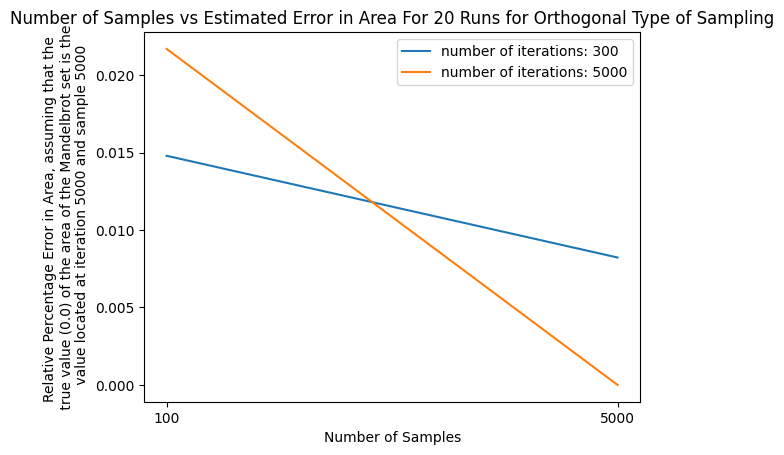

In [55]:
plot_error(plot_iterations, number_iterations, number_samples)